In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

#한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic' # SejongGeulggot, Moneygraphy Rounded
plt.rcParams['axes.unicode_minus'] = False

In [4]:
def analyze_nst_price_correlation(nst_file, price_file, max_lag=400):
    nst_df = pd.read_csv(nst_file)
    price_df = pd.read_csv(price_file)
    
    nst_df['date'] = pd.to_datetime(nst_df['date'])
    price_df['priceDate'] = pd.to_datetime(price_df['priceDate'])
    
    price_df = price_df[price_df['item'] == '대게'].copy()
    
    age_groups = ['20대', '30대', '40대', '50대', '60대 이상']
    results = []
    
    for age in age_groups:
        correlations = []
        
        for lag in range(1, max_lag + 1):
            nst_lagged = nst_df.copy()
            nst_lagged['date'] = nst_lagged['date'] + pd.Timedelta(days=lag)
            
            merged_df = pd.merge(
                price_df[['priceDate', 'avgPrice']],
                nst_lagged[['date', age]],
                left_on='priceDate',
                right_on='date',
                how='inner'
            )
            
            if not merged_df.empty:
                corr, p_value = stats.pearsonr(merged_df['avgPrice'], merged_df[age])
                correlations.append({
                    'age_group': age,
                    'lag': lag,
                    'correlation': corr,
                    'p_value': p_value,
                    'abs_correlation': abs(corr),
                    'sample_size': len(merged_df)
                })
        
        if correlations:
            corr_df = pd.DataFrame(correlations)
            best_lag = corr_df.loc[corr_df['abs_correlation'].idxmax()]
            results.append(best_lag)
            
            plt.figure(figsize=(12, 6))
            plt.plot(corr_df['lag'], corr_df['correlation'], 
				#marker='o',                # 마커 형태
				linewidth=2,            # 선 굵기
				color='#0076d8ff',          # 선 색상 (빨간색 계열)
				markersize=3,             # 마커 크기
				#markerfacecolor='white',  # 마커 내부 색상
				markeredgecolor='#0076d8ff' # 마커 테두리 색상		
                     
                     )
            plt.title(f'대개 가격과 {age} NST 점수의 시차별 상관계수')
            plt.xlabel('시차 (일)')
            plt.ylabel('상관계수')
            plt.grid(True)
            plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
            plt.show()
            # plt.savefig(f'lag_correlation_광어_{age}.png')
            plt.close()
    
    results_df = pd.DataFrame(results)
    
    print("\n=== 대게 가격과 연령대별 최적 시차 분석 결과 ===")
    print("\n{:<10} {:<5} {:<12} {:<10} {:<10}".format('연령대', '시차', '상관계수', 'p-value', '표본 수'))
    print("-" * 50)
    
    for _, row in results_df.iterrows():
        print("{:<10} {:<5d} {:<12.4f} {:<10.4f} {:<10d}".format(
            row['age_group'],
            int(row['lag']),
            row['correlation'],
            row['p_value'],
            row['sample_size']
        ))
    
    return results_df

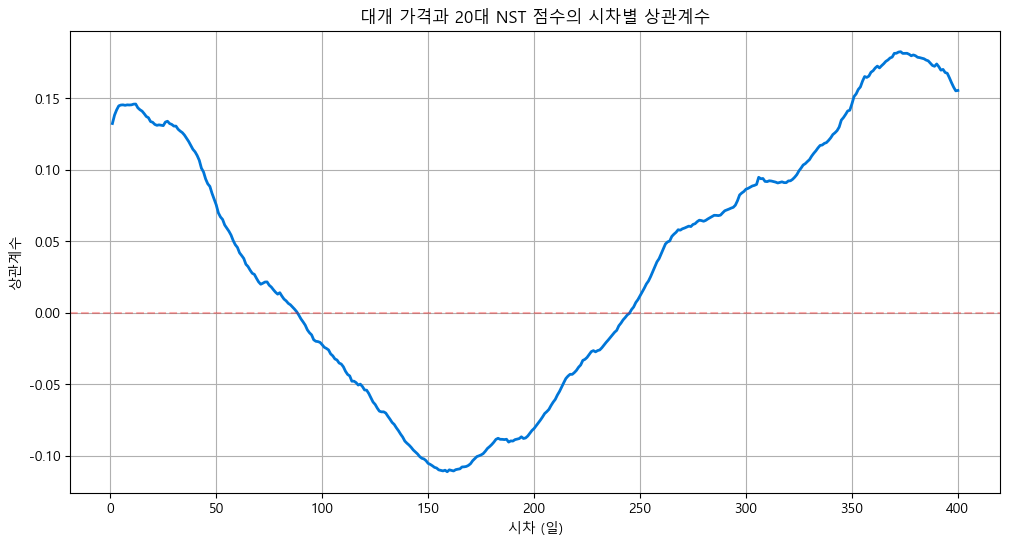

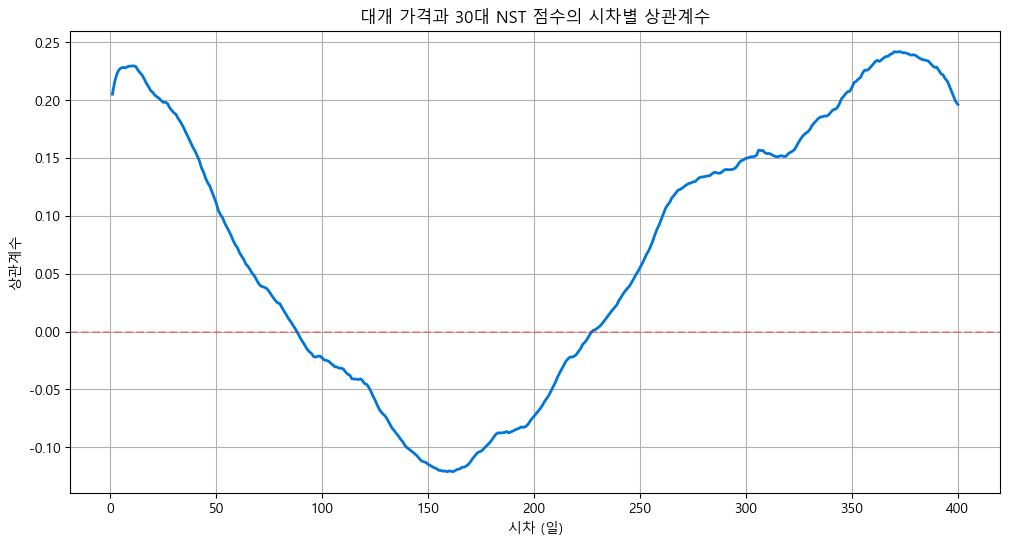

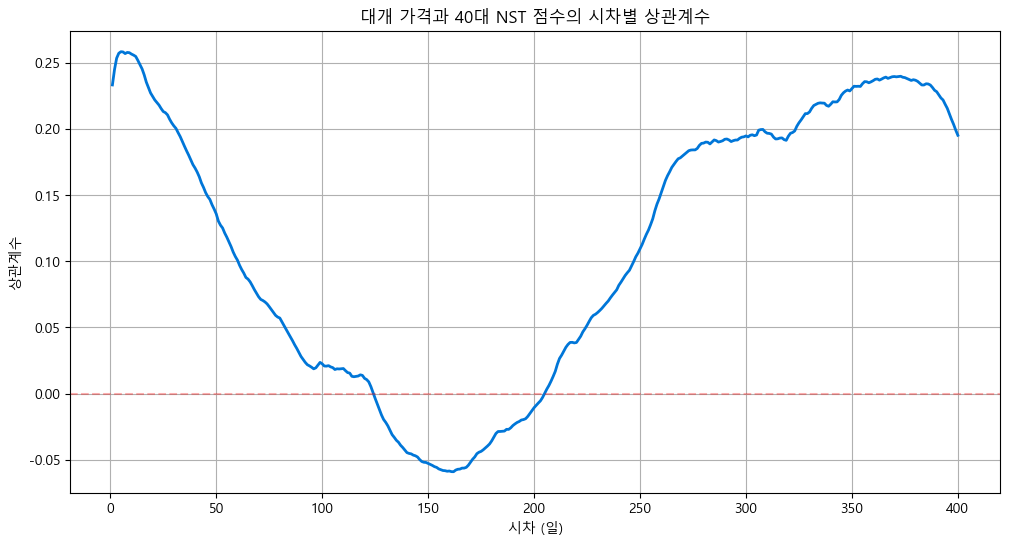

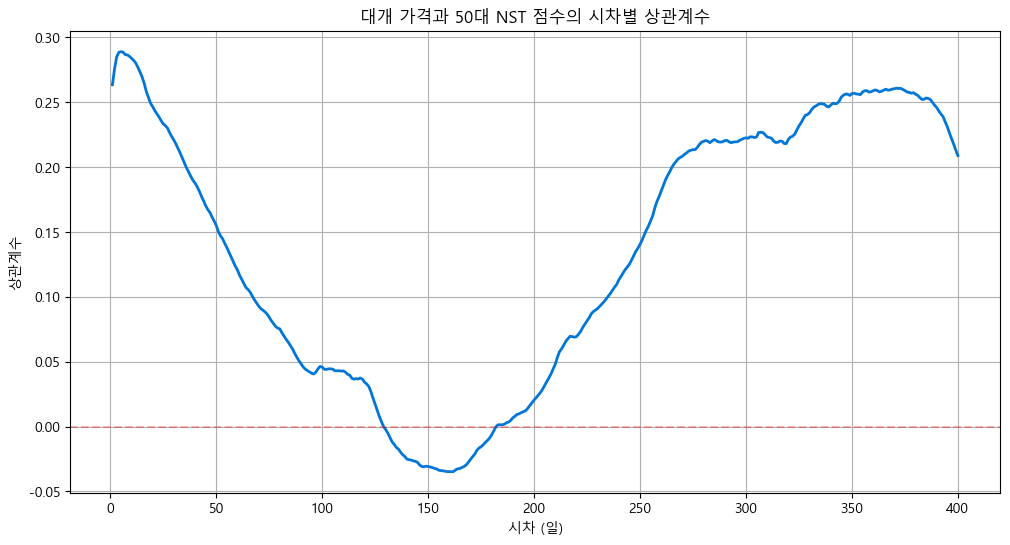

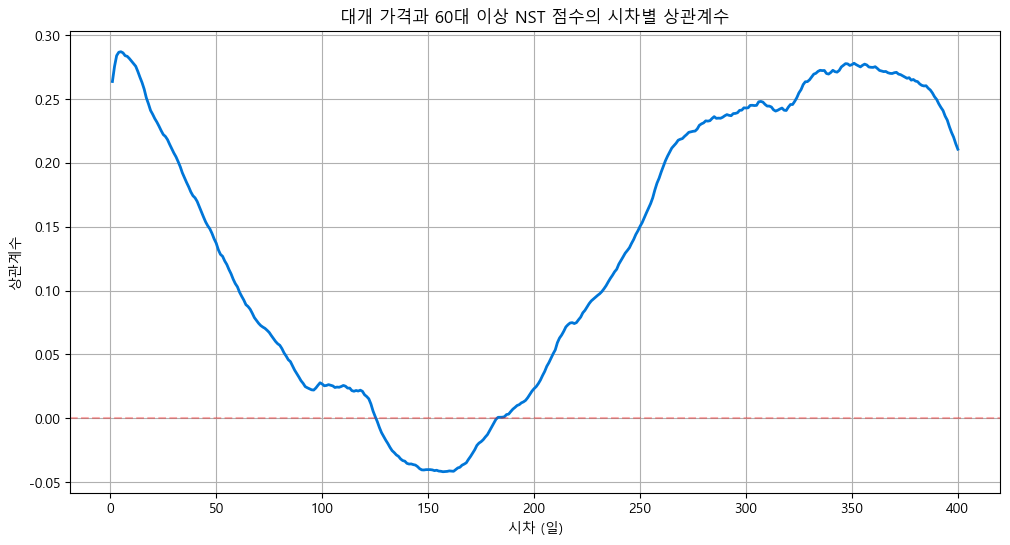


=== 대게 가격과 연령대별 최적 시차 분석 결과 ===

연령대        시차    상관계수         p-value    표본 수      
--------------------------------------------------
20대        373   0.1826       0.0000     2934      
30대        370   0.2417       0.0000     2937      
40대        5     0.2583       0.0000     3288      
50대        5     0.2890       0.0000     3288      
60대 이상     5     0.2870       0.0000     3288      


In [5]:
# 분석 실행
results = analyze_nst_price_correlation('../../data/processed/그룹화_nst_대게_trend_2025-01-17.csv', '../../data/processed/daily_item_average_prices.csv')